In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 2: Factor Loadings

In [91]:
studies = ['joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

data = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    ## Convert to DataFrame.
    loadings = DataFrame(loadings.round(3), columns=design.columns, index=design.index)
    loadings = loadings.melt(var_name='subscale', value_name='loading', ignore_index=False).reset_index()
    loadings = loadings.query('loading > 0')
    loadings.insert(0, 'study', study)
    
    ## Append.
    data.append(loadings)
    
data = concat(data)
data['factor'] = np.where(data.subscale == 'general', 1, 0)
data = data.pivot_table('loading','item','factor').merge(
    data.query('factor==0')[['item','subscale']].set_index('item'),
    left_index=True,
    right_on='item',
)
data['delta'] = data[1] - data[0]
data = data.sort_values(['delta'], ascending=False)

# order = [5, 40, 41, 48, 49, 50, 1, 2, 3, 4, 15, 16, 17, 18, 44, 45, 46, 47, 51, 38, 39, 42, 43, 52,
#          6,  7,  8,  9, 10, 11, 21, 22, 23, 24, 25, 12, 13, 14, 19, 20, 36, 37, 26, 27, 28, 29, 30,
#          31, 32, 33, 34, 35]
# data = data.loc[order]

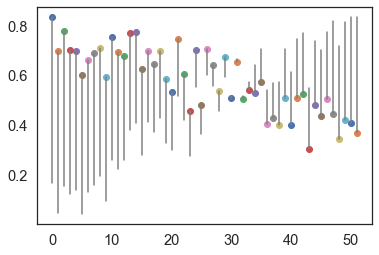

In [95]:
for i, (y1, y2) in enumerate(zip(data[0], data[1])):

    plt.scatter(i,y2)
    plt.plot([i,i], [y1,y2], color='0.5')


In [75]:
data.pivot_table(['loading','subscale'],'item','factor')

loading       
factor       0      1
item                 
1        0.556  0.704
2        0.517  0.747
3        0.169  0.836
4        0.125  0.703
5        0.043  0.604
6        0.260  0.754
7        0.380  0.772
8        0.224  0.696
9        0.835  0.368
10       0.719  0.347
11       0.703  0.438
12       0.261  0.680
13       0.422  0.608
14       0.519  0.511
15       0.412  0.698
16       0.576  0.403
17       0.199  0.712
18       0.283  0.628
19       0.570  0.429
20       0.576  0.543
21       0.666  0.655
22       0.601  0.708
23       0.641  0.529
24       0.330  0.588
25       0.373  0.648
26       0.705  0.512
27       0.773  0.506
28       0.613  0.402
29       0.550  0.305
30       0.300  0.535
31       0.542  0.406
32       0.364  0.480
33       0.745  0.510
34       0.813  0.423
35       0.737  0.483
36       0.818  0.447
37       0.833  0.411
38       0.156  0.778
39       0.095  0.594
40       0.133  0.664
41       0.049  0.700
42       0.708  0.575
43       0.769  0.525
44       0.596  0.673
45       0.520  0.507
46       0.162  0.691
47       0.139  0.700
48       0.557  0.644
49       0.456  0.539
50       0.278  0.457
51       0.428  0.698
52       0.408  0.774

In [73]:
data.query('factor == 0')

,study,item,subscale,loading,factor
89,joint,38,EN,0.156,0
90,joint,39,EN,0.095,0
93,joint,42,EN,0.708,0
94,joint,43,EN,0.769,0
103,joint,52,EN,0.408,0
108,joint,5,NVEA,0.043,0
143,joint,40,NVEA,0.133,0
144,joint,41,NVEA,0.049,0
151,joint,48,NVEA,0.557,0
152,joint,49,NVEA,0.456,0


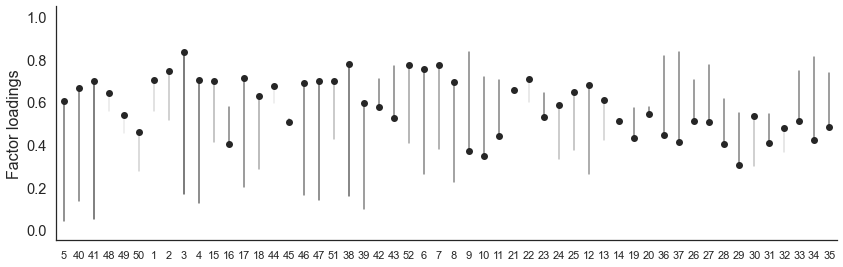

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,4))


## Plot connecting lines.
for i, j in enumerate(order):
    y1, = data.query(f'item == {j} and subscale == "general"').loading
    y2, = data.query(f'item == {j} and subscale != "general"').loading
    if y2 < y1: color = '%0.2f' %(1 - (y1 - y2))
    else: color = '0.5'
    ax.plot([i,i], [y1,y2], color=color)

sns.stripplot(x='item', y='loading', hue='factor', data=data, order=order, hue_order=[1],
              color='0.2', jitter=False, size=7, ax=ax)

ax.set(xlabel='', ylim=(-0.05, 1.05), ylabel='Factor loadings')
ax.set_xticklabels(order, fontsize=11)
ax.legend_.set_visible(False)

sns.despine()
plt.tight_layout()

In [60]:
1 - (0.4 - 0.2)

0.8

In [43]:
data.query('subscale == "general"')

,study,item,subscale,loading,factor
0,joint,1,general,0.704,1
1,joint,2,general,0.747,1
2,joint,3,general,0.836,1
3,joint,4,general,0.703,1
4,joint,5,general,0.604,1
5,joint,6,general,0.754,1
6,joint,7,general,0.772,1
7,joint,8,general,0.696,1
8,joint,9,general,0.368,1
9,joint,10,general,0.347,1


In [ ]:
import matplotlib.gridspec as gridspec
sns.set_theme(style='white', context='notebook', font_scale=1.33)

fig = plt.figure(figsize=(12,6), constrained_layout=True)

## Initialize panels.
spec = fig.add_gridspec(2, 1, left=0.12, right=0.98, top=0.98, bottom=0.12, wspace=0, hspace=0)

order = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 5, 40, 41, 48, 49, 50, 12, 13, 14, 19, 20, 36, 37, 38, 39, 
         42, 43, 52, 44, 45, 46, 47, 51, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
         32, 33, 34, 35]

axes = [plt.subplot(spec[0]), plt.subplot(spec[1])]

for x, (y1, y2) in data.iterrows():
    p = y2 / (y1 + y2)
    axes[0].bar(x, y2, 1, color=cm.Blues(p))
    axes[1].bar(x, y1, 1, color=cm.Blues(1-p))
    
axes[1].invert_yaxis()

In [ ]:
ax.bar?

#### Model 2a [Bifactor w/ 10 groups, joint data]

In [ ]:
studies = ['joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

stats = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    ## Convert to DataFrame.
    loadings = DataFrame(loadings.round(3), columns=design.columns, index=design.index)
    
    ## Re-organize DataFrame.
    cols = ['general','PVA','PPhysA','NVEA','SexA','EN','PN','WSV','WIPV','PeerVA','PeerPhysA']
    idx = np.concatenate([np.where(loadings[col])[0]+1 for col in cols[1:]])
    loadings = loadings.loc[idx, cols]
    
    ## Compute summary.
    loadings = loadings.replace({0:np.nan})
    averages = loadings.median()
    averages.name = 'summary'
    loadings = loadings.append(averages)
    
    ## Format DataFrame.
    loadings.loc[:,:] = np.where(loadings.notnull(), loadings.applymap(lambda x: '%0.3f' %x), '')

In [ ]:
print(loadings.to_latex())

## Section 3: Variance Decomposition

In [ ]:
studies = ['teicher2015', 'tuominen2022', 'joint']

## Load design data.
design = read_csv(os.path.join('data', 'design.csv'), index_col=0)
design = design[design.columns[:11]]

stats = []
for study in studies:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', study, '2plq_m2_summary.tsv'), sep='\t', index_col=0)
    
    ## Extract factor loadings.
    loadings = np.zeros_like(design).astype(float)
    for i, j in np.column_stack([np.where(design)]).T:
        loadings[i,j] = summary.loc[f'lambda[{i+1},{j+1}]','Mean']
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Coefficient omega hierachical.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Preallocate space.
    omega   = np.zeros(len(design.columns))
    omega_s = np.zeros(len(design.columns))
        
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Restrict to items in group.
        L = loadings[design[col]==1]
        
        ## Compute squared sum of factor loadings.
        A = np.square(np.sum(L, axis=0))
        
        ## Compute sum of error variances.
        B = np.sum(1 - np.square(L).sum(axis=1))
        
        ## Compute total variance.
        C = np.sum(A) + B
        
        ## Compute coefficient omega.
        omega[i] = A.sum() / C
        
        ## Compute coefficient omega subscale.
        omega_s[i] = A[i] / C
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Explained common variance.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Compute sum of squares.
    ss = np.square(loadings).sum(axis=0)
    
    ## Compute explained common variance.
    ecv = ss / ss.sum()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### H-index
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Preallocate space.
    H = np.zeros(len(design.columns))
    
    ## Iterate over factors.
    for i, col in enumerate(design.columns):
        
        ## Compute squared loadings.
        s = np.square(loadings[:,i])
        
        ## Compute H-index.
        H[i] = 1. / (1 + 1 / np.sum(s / (1-s)))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Convert to DataFrame.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    stats.append(DataFrame(dict(
        subscale = design.columns,
        study = np.repeat(study, design.columns.size),
        ecv = ecv,
        omega = omega,
        omega_s = omega_s,
        H = H
    )))
    
## Concatenate DataFrames.
stats = concat(stats).replace({'teicher2015':1, 'tuominen2022': 2, 'joint': 3})

## Convert to pivot table.
stats = stats.pivot_table(['omega','omega_s','ecv','H'], 'subscale', 'study')

## Re-organize table.
index = ['general', 'PVA', 'PPhysA', 'NVEA', 'SexA', 'EN', 'PN', 'WSV', 'WIPV', 'PeerVA', 'PeerPhysA']
stats = stats.loc[index, ['omega','omega_s','ecv','H']]

In [ ]:
stats.round(3)

In [ ]:
print(stats.round(3).to_latex())